In [1]:
## import required package
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier,VQC
from qiskit_machine_learning.neural_networks import EstimatorQNN,NeuralNetwork,SamplerQNN
from sklearn.model_selection import train_test_split

In [2]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■──────────────░─»
     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
q_3: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«q_1: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_2: ────────────┤ X ├┤ Rz(θ[3]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_3: ┤ Rz(-π/2) ├──■──┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_1: ────────────┤ X ├┤ Rz(θ[6]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[7]) ├┤ X ├┤ Ry(θ[8]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«q_3: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«     ┌──────────┐     ┌───────────┐┌───┐┌───────────┐                 ░ 
«q_0: ┤ Rz(-π/2) ├──■──┤ Ry(θ[10]) ├┤ X ├┤ Ry(θ[11]) ├──■──────────────░─
«     └──────────┘  │  └───────────┘└─┬─┘└───────────┘  │              ░ 
«q_1: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                   │                 │                 │              ░ 
«q_2: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                 ┌─┴─┐ ┌──────────┐  │               ┌─┴─┐┌─────────┐ ░ 
«q_3: ────────────┤ X ├─┤ Rz(θ[9]) ├──■───────────────┤ X ├┤ Rz(π/2) ├─░─
«                 └───┘ └──────────┘                  └───┘└─────────┘ ░

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw()

┌───┐┌──────────┐                  ░                  »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■───────────────░──────────────────»
                 └─┬─┘└──────────┘  │               ░             ┌───┐»
q_1: ──────────────┼────────────────┼───────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────┐┌─┴─┐┌──────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├─░───────────────┼──»
     └──────────┘     └──────────┘└───┘└──────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                    ░ └──────────┘     »
«                                   ░ 
«q_0: ──────────────────────────────░─
«     ┌──────────┐                  ░ 
«q_1: ┤ Rz(θ[3]) ├──■───────────────░─
«     └──────────┘  │               ░ 
«q_2: ──────────────┼───────────────░─
«     ┌──────────┐┌─┴─┐┌──────────┐ ░ 
«q_3: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├─░─
«     └──────────┘└───┘└──────────┘ ░

In [6]:
from torch.utils.data import Dataset,DataLoader
class myDataset(Dataset):  
    def __init__(self, Xnp, Ynp):
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp

    def __len__(self):
        return self.nobs

    def __getitem__(self, index):     
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],


'\nn_samples_show = 6\n\ndata_iter = iter(train_loader)\nfig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))\n\nwhile n_samples_show > 0:\n    images, targets = data_iter.__next__()\n\n    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap=\'gray\')\n    axes[n_samples_show - 1].set_xticks([])\n    axes[n_samples_show - 1].set_yticks([])\n    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))\n    \n    n_samples_show -= 1\n'

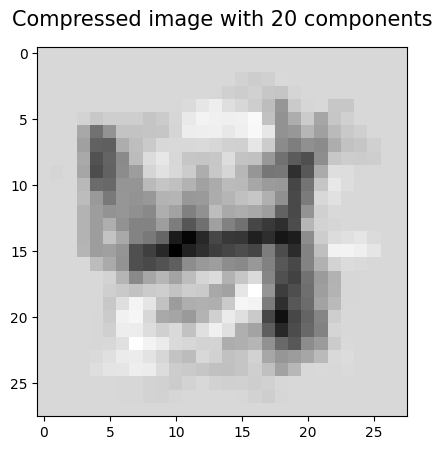

In [7]:
import torch
from torchvision import datasets,transforms
from sklearn.decomposition import PCA
from torch.utils.data import Dataset,DataLoader
# Concentrating on the first 100 samples
#n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
num_samples = 40
X_train.data = X_train.data[:num_samples]
X_train.targets = X_train.targets[:num_samples]
y_one_hot = np.zeros((num_samples, 10))
for i in range(num_samples):
    y_one_hot[i, X_train.targets[i]] = 1
y_train = torch.from_numpy(y_one_hot)
print(y_train)


mnist = torch.flatten(X_train.data, start_dim=1)

print(X_train.targets)

pca_10 = PCA(n_components=8)
mnist_pca_10_reduced = pca_10.fit_transform(mnist)
mnist_pca_10_recovered = pca_10.inverse_transform(mnist_pca_10_reduced)

image_pca_10 = mnist_pca_10_recovered[2,:].reshape([28,28])
plt.imshow(image_pca_10, cmap='gray_r')
plt.title('Compressed image with 20 components', fontsize=15, pad=15)
#plt.savefig("image_pca_10.png")

train_data = myDataset(mnist_pca_10_reduced,y_train)
train_loader = DataLoader(train_data,batch_size=2, shuffle=True)

#train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)




'''
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1
'''

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],


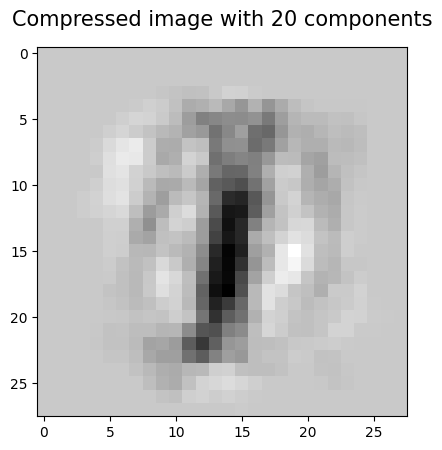

In [8]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))


X_test.data = X_test.data[:num_samples]
X_test.targets = X_test.targets[:num_samples]

mnist_test = torch.flatten(X_test.data, start_dim=1)
y_one_hot = np.zeros((num_samples, 10))
for i in range(num_samples):
    y_one_hot[i, X_test.targets[i]] = 1
y_test = torch.from_numpy(y_one_hot)
print(y_test)

print(mnist_test.shape)

pca_10 = PCA(n_components=8)
mnist_test_pca_10_reduced = pca_10.fit_transform(mnist_test)
mnist_test_pca_10_recovered = pca_10.inverse_transform(mnist_test_pca_10_reduced)

image_test_pca_10 = mnist_test_pca_10_recovered[2,:].reshape([28,28])
plt.imshow(image_test_pca_10, cmap='gray_r')
plt.title('Compressed image with 20 components', fontsize=15, pad=15)
#plt.savefig("image_pca_10.png")

test_data = myDataset(mnist_test_pca_10_reduced,y_test)
test_loader = DataLoader(test_data,batch_size=2, shuffle=True)

#test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=True)

In [10]:
feature_map = ZFeatureMap(32)
feature_map.decompose().draw()

┌───┐┌─────────────┐ ┌───┐┌─────────────┐ 
 q_0: ┤ H ├┤ P(2.0*x[0]) ├─┤ H ├┤ P(2.0*x[0]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_1: ┤ H ├┤ P(2.0*x[1]) ├─┤ H ├┤ P(2.0*x[1]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_2: ┤ H ├┤ P(2.0*x[2]) ├─┤ H ├┤ P(2.0*x[2]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_3: ┤ H ├┤ P(2.0*x[3]) ├─┤ H ├┤ P(2.0*x[3]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_4: ┤ H ├┤ P(2.0*x[4]) ├─┤ H ├┤ P(2.0*x[4]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_5: ┤ H ├┤ P(2.0*x[5]) ├─┤ H ├┤ P(2.0*x[5]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_6: ┤ H ├┤ P(2.0*x[6]) ├─┤ H ├┤ P(2.0*x[6]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_7: ┤ H ├┤ P(2.0*x[7]) ├─┤ H ├┤ P(2.0*x[7]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_8: ┤ H ├┤ P(2.0*x[8]) ├─┤ H ├┤ P(2.0*x[8]) ├─
      ├───┤├─────────────┤ ├───┤├─────────────┤ 
 q_9: ┤ H ├┤ P(2.0*x[9]) ├─┤ H ├┤ P(2.0*x[9]) ├─
      ├───┤├─────────────┴┐├───┤├─────────────┴┐
q_10: ┤ H ├┤ P(2.0*x[10]) ├┤ H ├┤ P(2.0*x[10]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_11: ┤ H ├┤ P(2.0*x[11]) ├┤ H ├┤ P(2.0*x[11]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_12: ┤ H ├┤ P(2.0*x[12]) ├┤ H ├┤ P(2.0*x[12]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_13: ┤ H ├┤ P(2.0*x[13]) ├┤ H ├┤ P(2.0*x[13]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_14: ┤ H ├┤ P(2.0*x[14]) ├┤ H ├┤ P(2.0*x[14]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_15: ┤ H ├┤ P(2.0*x[15]) ├┤ H ├┤ P(2.0*x[15]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_16: ┤ H ├┤ P(2.0*x[16]) ├┤ H ├┤ P(2.0*x[16]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_17: ┤ H ├┤ P(2.0*x[17]) ├┤ H ├┤ P(2.0*x[17]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_18: ┤ H ├┤ P(2.0*x[18]) ├┤ H ├┤ P(2.0*x[18]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_19: ┤ H ├┤ P(2.0*x[19]) ├┤ H ├┤ P(2.0*x[19]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_20: ┤ H ├┤ P(2.0*x[20]) ├┤ H ├┤ P(2.0*x[20]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_21: ┤ H ├┤ P(2.0*x[21]) ├┤ H ├┤ P(2.0*x[21]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_22: ┤ H ├┤ P(2.0*x[22]) ├┤ H ├┤ P(2.0*x[22]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_23: ┤ H ├┤ P(2.0*x[23]) ├┤ H ├┤ P(2.0*x[23]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_24: ┤ H ├┤ P(2.0*x[24]) ├┤ H ├┤ P(2.0*x[24]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_25: ┤ H ├┤ P(2.0*x[25]) ├┤ H ├┤ P(2.0*x[25]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_26: ┤ H ├┤ P(2.0*x[26]) ├┤ H ├┤ P(2.0*x[26]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_27: ┤ H ├┤ P(2.0*x[27]) ├┤ H ├┤ P(2.0*x[27]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_28: ┤ H ├┤ P(2.0*x[28]) ├┤ H ├┤ P(2.0*x[28]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_29: ┤ H ├┤ P(2.0*x[29]) ├┤ H ├┤ P(2.0*x[29]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_30: ┤ H ├┤ P(2.0*x[30]) ├┤ H ├┤ P(2.0*x[30]) ├
      ├───┤├──────────────┤├───┤├──────────────┤
q_31: ┤ H ├┤ P(2.0*x[31]) ├┤ H ├┤ P(2.0*x[31]) ├
      └───┘└──────────────┘└───┘└──────────────┘

In [9]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
#ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
#ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
#ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
#ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)
def parity(x):
    return "{:b}".format(x).count("0") % 10

output_shape = 10
#output_shape = np.array(output_shape)
QQnn = SamplerQNN(
    circuit=circuit.decompose(),
    output_shape = output_shape,
    input_params=feature_map.parameters,
    interpret = parity,
    weight_params=ansatz.parameters,
)

In [11]:
feature_map = ZFeatureMap(32)

ansatz = QuantumCircuit(32, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(32, "с1"), list(range(32)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([i for i in range(16)], [(16+i) for i in range(16)], "p1"), list(range(32)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(24, 32)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([i for i in range(4)], [(4+i) for i in range(4)], "p2"), list(range(24, 32)), inplace=True)

# Third Convolutional Layer
#ansatz.compose(conv_layer(2, "c3"), list(range(30, 32)), inplace=True)

# Third Pooling Layer
#ansatz.compose(pool_layer([0], [1], "p3"), list(range(30, 32)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(32)
circuit.compose(feature_map, range(32), inplace=True)
circuit.compose(ansatz, range(32), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
'''
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
'''

# parity maps bitstrings to 0 or 1
def parity(x):
    
    return "{:b}".format(x).count("1") % 10

output_shape = [40,10]
QQnn = SamplerQNN(
    circuit=circuit.decompose(),
    output_shape = output_shape,
    input_params=feature_map.parameters,
    interpret = parity,
    weight_params=ansatz.parameters,
)

In [10]:
circuit.draw()

┌───────────────────────────────────────────────────────┐»
q_0: ┤0                                                      ├»
     │                                                       │»
q_1: ┤1                                                      ├»
     │                                                       │»
q_2: ┤2                                                      ├»
     │                                                       │»
q_3: ┤3                                                      ├»
     │  ZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) │»
q_4: ┤4                                                      ├»
     │                                                       │»
q_5: ┤5                                                      ├»
     │                                                       │»
q_6: ┤6                                                      ├»
     │                                                       │»
q_7: ┤7                                                      ├»
     └───────────────────────────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_1: ┤1                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_2: ┤2                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_3: ┤3                                                                                                                                                                                    ├»
«     │  Convolutional Layer(с1[0],с1[1],с1[2],с1[3],с1[4],с1[5],с1[6],с1[7],с1[8],с1[9],с1[10],с1[11],с1[12],с1[13],с1[14],с1[15],с1[16],с1[17],с1[18],с1[19],с1[20],с1[21],с1[22],с1[23]) │»
«q_4: ┤4                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_5: ┤5                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_6: ┤6                                                                                                                                                                                    ├»
«     │                                                                                                                                                                                     │»
«q_7: ┤7                                            

In [11]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
vqc = VQC(
    num_qubits=28,
    feature_map=feature_map,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=3),
    callback=callback_graph,
)

NameError: name 'callback_graph' is not defined

In [12]:
classifier = NeuralNetworkClassifier(
    QQnn,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=1),  # Set max iterations here
    callback=callback_graph
)

In [13]:
print(train_data.Xnp.shape)

(40, 8)


In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(train_data.Xnp,train_data.Ynp)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(train_data.Xnp,train_data.Ynp), 2)}%")

Traceback (most recent call last):
  File "/opt/anaconda3/envs/IBMQ/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 261, in calcfc
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = fun(np.copy(x), *args)
  File "/opt/anaconda3/envs/IBMQ/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/trainable_model.py", line 275, in objective
    objective_value = function.objective(objective_weights)
  File "/opt/anaconda3/envs/IBMQ/lib/python3.10/site-packages/qiskit_machine_learning/algorithms/objective_functions.py", line 164, in objective
    val += probs[:, i] @ self._loss(np.full(num_samples, i), self._y)
  File "/opt/anaconda3/envs/IBMQ/lib/python3.10/site-packages/qiskit_machine_learning/utils/loss_functions/loss_functions.py", line 32, in __call__
    return self.evaluate(predict, target

Hey [[3.09917596e-02 1.33410118e-01 1.82410338e-01 2.52833347e-01
  2.54929650e-01 1.10096729e-01 3.18519264e-02 3.47613178e-03
  0.00000000e+00 0.00000000e+00]
 [4.31909985e-02 1.32093421e-01 1.97036664e-01 2.50182833e-01
  2.39409513e-01 1.07129357e-01 3.00395679e-02 9.17645513e-04
  0.00000000e+00 0.00000000e+00]
 [2.95092759e-02 8.54183884e-02 2.15994655e-01 3.39072677e-01
  2.37846705e-01 8.40460693e-02 8.02753711e-03 8.46924221e-05
  0.00000000e+00 0.00000000e+00]
 [3.03782164e-02 9.59618256e-02 2.17093639e-01 2.81411973e-01
  2.70434616e-01 8.17762874e-02 1.89592918e-02 3.98415099e-03
  0.00000000e+00 0.00000000e+00]
 [4.59124801e-02 1.46277941e-01 2.01207687e-01 2.30444152e-01
  2.02914929e-01 1.24604595e-01 3.91561549e-02 9.48206094e-03
  0.00000000e+00 0.00000000e+00]
 [3.24451863e-02 1.37057178e-01 2.54000403e-01 2.99786872e-01
  2.07382826e-01 5.96060008e-02 9.71279844e-03 8.73602553e-06
  0.00000000e+00 0.00000000e+00]
 [3.56183675e-02 9.35515316e-02 2.08676761e-01 2.96851